In [2]:
!pip install tensorflow

In [3]:
!pip install wandb

In [4]:
!wandb login 4145cec4ec9dddbd0bee62113dd35e5a71801737

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns
import tensorflow as tf
import keras
import os 
import time
import warnings
import wandb
warnings.simplefilter(action='ignore', category=FutureWarning)
from math import sqrt
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
from keras import optimizers
from keras import backend as K
from wandb.keras import WandbCallback
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
plt.style.use('ggplot')

In [3]:
wandb.init(project = "Stock Price Time Series Project")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: scarfe. Use `wandb login --relogin` to force relogin


In [4]:
df = pd.read_csv("NewMachine.csv")

df.drop(['OpeningTime','CloseTime','PredictValue'], inplace = True, axis = 1)

In [5]:
df.head()

,Open,High,Low,Close,Volume,RSI,MACD,MACDSIGNAL,MACDHIST,STOCHK,STOCHD
0,8054.34,8083.42,8054.34,8080.11,141.913060,50.52,1.02,8.64,-7.63,31.91,24.17
1,8081.09,8081.30,8050.37,8050.37,128.045741,42.11,-1.64,6.59,-8.23,27.88,24.98
2,8050.27,8059.39,8042.89,8054.03,193.106203,43.36,-3.41,4.59,-8.00,35.03,31.61
3,8054.03,8054.03,8020.00,8027.63,290.159767,37.13,-6.87,2.30,-9.16,13.17,25.36
4,8029.22,8036.72,8010.00,8026.66,243.755800,36.92,-9.57,-0.08,-9.50,20.74,22.98


In [6]:
##Scaling Data to Observe Bivariate Analysis 
sc = MinMaxScaler(feature_range=(0,1))
df_scaled= sc.fit_transform(df)

In [7]:
df_scaled

array([[0.06424012, 0.06146096, 0.06593032, ..., 0.60146314, 0.3191    ,
        0.24426478],
       [0.06465264, 0.0614283 , 0.06586905, ..., 0.60094613, 0.2788    ,
        0.25245073],
       [0.06417736, 0.06109074, 0.06575362, ..., 0.60114431, 0.3503    ,
        0.31945427],
       ...,
       [0.58934753, 0.58641045, 0.59105907, ..., 0.61042464, 0.2232    ,
        0.34451743],
       [0.59005598, 0.58682875, 0.59212529, ..., 0.61067453, 0.4044    ,
        0.30682163],
       [0.59016131, 0.58832615, 0.5922307 , ..., 0.61360425, 0.6071    ,
        0.41596766]])

In [8]:
#validation data, training data and test data will be seperated
data_training = df[:190000]
validation_data = df[190000:205000]
data_testing = df[205000:]

In [9]:
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

In [10]:
# Normalisation
#sc = MinMaxScaler()
train = sc1.fit_transform(data_training)
val = sc1.fit_transform(validation_data)
test = sc2.fit_transform((data_testing))
                         #.iloc[:, 0]).to_frame()
print(train.shape,val.shape,test.shape)

(190000, 11) (15000, 11) (5049, 11)


In [11]:
train.shape[0]

190000

In [12]:
train

array([[0.06610155, 0.06341503, 0.06783345, ..., 0.60146314, 0.31913191,
        0.24426478],
       [0.06652602, 0.06338133, 0.06777042, ..., 0.60094613, 0.27882788,
        0.25245073],
       [0.06603697, 0.06303303, 0.06765165, ..., 0.60114431, 0.35033503,
        0.31945427],
       ...,
       [0.9483949 , 0.9480782 , 0.94912138, ..., 0.57400993, 0.31753175,
        0.38888327],
       [0.94803517, 0.9478841 , 0.94998751, ..., 0.577224  , 0.34763476,
        0.36078828],
       [0.9493262 , 0.9484939 , 0.95100719, ..., 0.58052425, 0.53305331,
        0.4036382 ]])

In [13]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop, WandbCallback()]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [14]:
##LSTM_MODEL

In [15]:
#Build and train the model
def fit_model(train,val,timesteps,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    print(Y_val.shape)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(units=64,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    #model.add(Dropout(0.2))
    
    model.add(LSTM(units=32,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    #model.add(Dropout(0.2))
    
    #for i in range(len(hl)-1):        
    model.add(LSTM(units=32,activation = 'relu',input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True))
    #model.add(Dropout(0.3))
    
    model.add(LSTM(units=16,input_shape = (X_train.shape[1],X_train.shape[2]),activation = 'relu'))
    #model.add(Dropout(0.4))
    
    model.add(Dense(1))
    from tensorflow import keras
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.0008), loss = 'mean_squared_error')
    
    print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    #model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [16]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [17]:
keras.__version__

'2.9.0'

In [21]:
timesteps = 5
lr = 1e-3
batch_size = 32
num_epochs = 150

In [23]:
#model,train_error,val_error =  fit_model(train,val,timesteps,lr,batch_size,num_epochs)

(14995,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             19456     
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 5, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 43,345
Trainable params: 43,345
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/150
5938/5938 [==============================] - 76s 12ms/step - loss: 3.1322e-04 - val_loss: 0.3258
Epoch 2/150
5938/5938 [==============================] - 72s 12ms/step - loss: 0.0014 - val_loss: 0.3133
Epoch 3/150
5938/5938 [==============================] - 81s 14ms/step - loss: 0.0012 - val_loss: 0.2668
Epoch 4/150
5938/5938 [==============================] - 73s 12ms/step - loss: 0.0013 - val_loss: 0.2213
Epoch 5/150
5938/5938 [==============================] - 71s 12ms/step - loss: 0.0010 - val_loss: 0.1717
Epoch 6/150
5938/5938 [==============================] - 72s 12ms/step - loss: 0.0013 - val_loss: 0.1687
Epoch 7/150
5938/5938 [==============================] - 72s 12ms/step - loss: 0.0012 - val_loss: 0.1320
Epoch 8/150
5938/5938 [==============================] - 71s 12ms/step - loss: 7.7322e-04 - val_loss: 0.1016
Epoch 9/150
5938/5938 [==============================] - 72s 12ms/step - loss: 3.9690e-04 - val_loss: 0.0522
Epoch 10/150
5936/5938 [==============

wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 2.0859e-04 - val_loss: 0.0345
Epoch 11/150
5934/5938 [============================>.] - ETA: 0s - loss: 1.1931e-04INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 76s 13ms/step - loss: 1.1940e-04 - val_loss: 0.0254
Epoch 12/150
5935/5938 [============================>.] - ETA: 0s - loss: 9.1220e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 9.1320e-05 - val_loss: 0.0229
Epoch 13/150
5935/5938 [============================>.] - ETA: 0s - loss: 8.7620e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 8.7721e-05 - val_loss: 0.0213
Epoch 14/150
5934/5938 [============================>.] - ETA: 0s - loss: 8.2344e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 76s 13ms/step - loss: 8.2451e-05 - val_loss: 0.0202
Epoch 15/150
5935/5938 [============================>.] - ETA: 0s - loss: 7.8345e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 7.8448e-05 - val_loss: 0.0189
Epoch 16/150
5937/5938 [============================>.] - ETA: 0s - loss: 7.4573e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 82s 14ms/step - loss: 7.4592e-05 - val_loss: 0.0184
Epoch 17/150
5934/5938 [============================>.] - ETA: 0s - loss: 7.1283e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 7.1396e-05 - val_loss: 0.0182
Epoch 18/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.7890e-05 - val_loss: 0.0190
Epoch 19/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.8401e-05 - val_loss: 0.0190
Epoch 20/150
5934/5938 [============================>.] - ETA: 0s - loss: 6.8797e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 6.8913e-05 - val_loss: 0.0178
Epoch 21/150
5938/5938 [==============================] - 73s 12ms/step - loss: 6.3490e-05 - val_loss: 0.0188
Epoch 22/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.2909e-05 - val_loss: 0.0188
Epoch 23/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.1006e-05 - val_loss: 0.0195
Epoch 24/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.4334e-05 - val_loss: 0.0195
Epoch 25/150
5938/5938 [==============================] - 73s 12ms/step - loss: 6.4458e-05 - val_loss: 0.0191
Epoch 26/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.2306e-05 - val_loss: 0.0185
Epoch 27/150
5938/5938 [==============================] - 71s 12ms/step - loss: 6.0689e-05 - val_loss: 0.0180
Epoch 28/150
5937/5938 [============================>.] - ETA: 0s - loss: 5.8932e-05INFO:tensorflow:Assets written to: /root/wandb/ru

wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 5.8954e-05 - val_loss: 0.0176
Epoch 29/150
5935/5938 [============================>.] - ETA: 0s - loss: 5.7735e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 81s 14ms/step - loss: 5.7870e-05 - val_loss: 0.0170
Epoch 30/150
5938/5938 [==============================] - ETA: 0s - loss: 5.4929e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 5.4929e-05 - val_loss: 0.0169
Epoch 31/150
5938/5938 [==============================] - 72s 12ms/step - loss: 5.6240e-05 - val_loss: 0.0170
Epoch 32/150
5938/5938 [==============================] - 72s 12ms/step - loss: 5.5857e-05 - val_loss: 0.0172
Epoch 33/150
5934/5938 [============================>.] - ETA: 0s - loss: 5.4529e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 5.4708e-05 - val_loss: 0.0167
Epoch 34/150
5935/5938 [============================>.] - ETA: 0s - loss: 5.3350e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 5.3507e-05 - val_loss: 0.0162
Epoch 35/150
5936/5938 [============================>.] - ETA: 0s - loss: 5.2084e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 5.2189e-05 - val_loss: 0.0160
Epoch 36/150
5934/5938 [============================>.] - ETA: 0s - loss: 5.1494e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 5.1683e-05 - val_loss: 0.0158
Epoch 37/150
5938/5938 [==============================] - ETA: 0s - loss: 5.1144e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 5.1144e-05 - val_loss: 0.0155
Epoch 38/150
5935/5938 [============================>.] - ETA: 0s - loss: 5.0235e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 5.0405e-05 - val_loss: 0.0150
Epoch 39/150
5938/5938 [==============================] - ETA: 0s - loss: 4.9633e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 4.9633e-05 - val_loss: 0.0143
Epoch 40/150
5938/5938 [==============================] - ETA: 0s - loss: 4.8622e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 4.8622e-05 - val_loss: 0.0139
Epoch 41/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.7833e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.7862e-05 - val_loss: 0.0136
Epoch 42/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.6639e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.6669e-05 - val_loss: 0.0133
Epoch 43/150
5938/5938 [==============================] - ETA: 0s - loss: 4.5884e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 4.5884e-05 - val_loss: 0.0133
Epoch 44/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.5436e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 83s 14ms/step - loss: 4.5572e-05 - val_loss: 0.0132
Epoch 45/150
5938/5938 [==============================] - 86s 15ms/step - loss: 4.5721e-05 - val_loss: 0.0134
Epoch 46/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.5337e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.5373e-05 - val_loss: 0.0131
Epoch 47/150
5934/5938 [============================>.] - ETA: 0s - loss: 4.5277e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.5563e-05 - val_loss: 0.0131
Epoch 48/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.4947e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.4985e-05 - val_loss: 0.0128
Epoch 49/150
5934/5938 [============================>.] - ETA: 0s - loss: 4.4473e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.4785e-05 - val_loss: 0.0128
Epoch 50/150
5935/5938 [============================>.] - ETA: 0s - loss: 4.3869e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.4136e-05 - val_loss: 0.0123
Epoch 51/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3300e-05 - val_loss: 0.0123
Epoch 52/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.5878e-05 - val_loss: 0.0140
Epoch 53/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.4779e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.4982e-05 - val_loss: 0.0115
Epoch 54/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.5316e-05 - val_loss: 0.0137
Epoch 55/150
5938/5938 [==============================] - 71s 12ms/step - loss: 4.5134e-05 - val_loss: 0.0119
Epoch 56/150
5938/5938 [==============================] - 73s 12ms/step - loss: 4.4917e-05 - val_loss: 0.0131
Epoch 57/150
5938/5938 [==============================] - 71s 12ms/step - loss: 4.4498e-05 - val_loss: 0.0120
Epoch 58/150
5938/5938 [==============================] - 71s 12ms/step - loss: 4.3773e-05 - val_loss: 0.0121
Epoch 59/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3134e-05 - val_loss: 0.0118
Epoch 60/150
5938/5938 [==============================] - 73s 12ms/step - loss: 4.3868e-05 - val_loss: 0.0121
Epoch 61/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3027e-05 - val_loss: 0.0116
Epoch 62/150
5938/5938 

wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.3258e-05 - val_loss: 0.0114
Epoch 64/150
5938/5938 [==============================] - 76s 13ms/step - loss: 4.2817e-05 - val_loss: 0.0116
Epoch 65/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3503e-05 - val_loss: 0.0116
Epoch 66/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3524e-05 - val_loss: 0.0115
Epoch 67/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3597e-05 - val_loss: 0.0115
Epoch 68/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.3553e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.3842e-05 - val_loss: 0.0113
Epoch 69/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.4106e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.4181e-05 - val_loss: 0.0112
Epoch 70/150
5938/5938 [==============================] - ETA: 0s - loss: 4.3785e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.3785e-05 - val_loss: 0.0111
Epoch 71/150
5938/5938 [==============================] - ETA: 0s - loss: 4.3514e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 4.3514e-05 - val_loss: 0.0109
Epoch 72/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.3270e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 4.3345e-05 - val_loss: 0.0108
Epoch 73/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.3093e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.3169e-05 - val_loss: 0.0106
Epoch 74/150
5938/5938 [==============================] - ETA: 0s - loss: 4.2484e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 4.2484e-05 - val_loss: 0.0105
Epoch 75/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.1989e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.2291e-05 - val_loss: 0.0103
Epoch 76/150
5934/5938 [============================>.] - ETA: 0s - loss: 4.1330e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 80s 13ms/step - loss: 4.1913e-05 - val_loss: 0.0102
Epoch 77/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.1621e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.1928e-05 - val_loss: 0.0101
Epoch 78/150
5938/5938 [==============================] - ETA: 0s - loss: 4.1848e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.1848e-05 - val_loss: 0.0100
Epoch 79/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.1354e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 4.1434e-05 - val_loss: 0.0098
Epoch 80/150
5936/5938 [============================>.] - ETA: 0s - loss: 4.1222e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.1541e-05 - val_loss: 0.0097
Epoch 81/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.1938e-05 - val_loss: 0.0101
Epoch 82/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.2482e-05 - val_loss: 0.0101
Epoch 83/150
5938/5938 [==============================] - 82s 14ms/step - loss: 4.2775e-05 - val_loss: 0.0102
Epoch 84/150
5938/5938 [==============================] - 83s 14ms/step - loss: 4.3121e-05 - val_loss: 0.0102
Epoch 85/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3181e-05 - val_loss: 0.0103
Epoch 86/150
5938/5938 [==============================] - 73s 12ms/step - loss: 4.3458e-05 - val_loss: 0.0103
Epoch 87/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.3789e-05 - val_loss: 0.0103
Epoch 88/150
5938/5938 [==============================] - 74s 13ms/step - loss: 4.3764e-05 - val_loss: 0.0103
Epoch 89/150
5938/5938 

wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 76s 13ms/step - loss: 4.8134e-05 - val_loss: 0.0096
Epoch 119/150
5937/5938 [============================>.] - ETA: 0s - loss: 4.4885e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 4.4931e-05 - val_loss: 0.0083
Epoch 120/150
5938/5938 [==============================] - 72s 12ms/step - loss: 4.7825e-05 - val_loss: 0.0109
Epoch 121/150
5938/5938 [==============================] - 70s 12ms/step - loss: 4.7758e-05 - val_loss: 0.0088
Epoch 122/150
5938/5938 [==============================] - 71s 12ms/step - loss: 4.5295e-05 - val_loss: 0.0087
Epoch 123/150
5935/5938 [============================>.] - ETA: 0s - loss: 4.3790e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.4010e-05 - val_loss: 0.0081
Epoch 124/150
5938/5938 [==============================] - ETA: 0s - loss: 4.1877e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 79s 13ms/step - loss: 4.1877e-05 - val_loss: 0.0079
Epoch 125/150
5935/5938 [============================>.] - ETA: 0s - loss: 4.0194e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 84s 14ms/step - loss: 4.0422e-05 - val_loss: 0.0078
Epoch 126/150
5934/5938 [============================>.] - ETA: 0s - loss: 3.9599e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 3.9856e-05 - val_loss: 0.0076
Epoch 127/150
5936/5938 [============================>.] - ETA: 0s - loss: 3.8738e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 76s 13ms/step - loss: 3.8904e-05 - val_loss: 0.0075
Epoch 128/150
5935/5938 [============================>.] - ETA: 0s - loss: 3.7329e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 3.7554e-05 - val_loss: 0.0073
Epoch 129/150
5934/5938 [============================>.] - ETA: 0s - loss: 3.5362e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 3.5618e-05 - val_loss: 0.0068
Epoch 130/150
5937/5938 [============================>.] - ETA: 0s - loss: 3.4139e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 3.4183e-05 - val_loss: 0.0066
Epoch 131/150
5935/5938 [============================>.] - ETA: 0s - loss: 3.2833e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 3.3060e-05 - val_loss: 0.0064
Epoch 132/150
5938/5938 [==============================] - ETA: 0s - loss: 3.2132e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 86s 15ms/step - loss: 3.2132e-05 - val_loss: 0.0062
Epoch 133/150
5935/5938 [============================>.] - ETA: 0s - loss: 3.0711e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 3.0941e-05 - val_loss: 0.0060
Epoch 134/150
5934/5938 [============================>.] - ETA: 0s - loss: 2.8983e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 78s 13ms/step - loss: 2.9248e-05 - val_loss: 0.0058
Epoch 135/150
5938/5938 [==============================] - ETA: 0s - loss: 2.8534e-05INFO:tensorflow:Assets written to: /root/wandb/run-20220808_181318-ame6ewke/files/model-best/assets


wandb: Adding directory to artifact (/root/wandb/run-20220808_181318-ame6ewke/files/model-best)... Done. 0.1s


5938/5938 [==============================] - 77s 13ms/step - loss: 2.8534e-05 - val_loss: 0.0057
Epoch 136/150
5938/5938 [==============================] - 73s 12ms/step - loss: 2.8082e-05 - val_loss: 0.0058
Epoch 137/150
5938/5938 [==============================] - 71s 12ms/step - loss: 2.8464e-05 - val_loss: 0.0061
Epoch 138/150
5938/5938 [==============================] - 71s 12ms/step - loss: 2.9578e-05 - val_loss: 0.0061
Epoch 139/150
5938/5938 [==============================] - 71s 12ms/step - loss: 3.0136e-05 - val_loss: 0.0060
Epoch 140/150
5938/5938 [==============================] - 72s 12ms/step - loss: 2.9988e-05 - val_loss: 0.0068
Epoch 141/150
5938/5938 [==============================] - 71s 12ms/step - loss: 3.2064e-05 - val_loss: 0.0067
Epoch 142/150
5938/5938 [==============================] - 71s 12ms/step - loss: 3.1724e-05 - val_loss: 0.0062
Epoch 143/150
5938/5938 [==============================] - 72s 12ms/step - loss: 3.0544e-05 - val_loss: 0.0065
Epoch 144/150
5

In [34]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

158/158 [==============================] - 1s 7ms/step
MSE = 0.0030444880624401717
RMSE = 0.05517687978166373
R-Squared Score = 0.9546165650945985


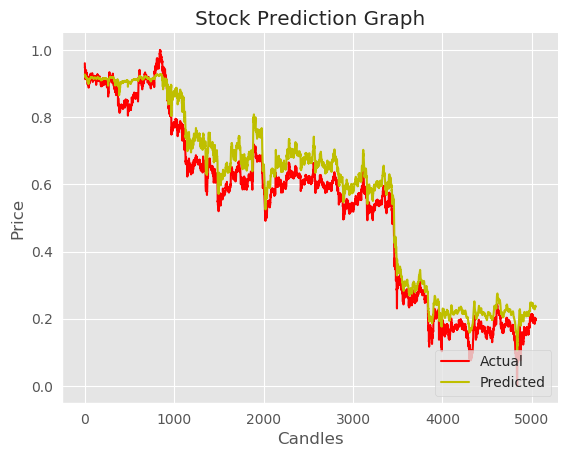

In [38]:
plot_data(true, predicted)

In [27]:
model.save("sequentialModel.h5")

In [ ]:
#GRU - MODEL

In [26]:
wandb.init(project = "Stock Price Time Series GRU Project")

epoch,▁▁▁▂▂▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
loss,█▆▂▂▁▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▃▂▂█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPs,2e-05
best_epoch,134
best_val_loss,0.00575
epoch,149
loss,3e-05
val_loss,0.0071


In [28]:
def gru_model(train,val,timesteps,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    print(Y_val.shape)
    
    # Adding Layers to the model
    global gru_model
    gru_model = Sequential()

    # Layer 1 of GRU with Dropout
    gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]), activation='tanh'))
    gru_model.add(Dropout(0.2))

    # Layer 2 of GRU with Dropout
    gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]), activation='tanh'))
    gru_model.add(Dropout(0.2))

    # Layer 3 of GRU with Dropout
    gru_model.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]), activation='tanh'))
    gru_model.add(Dropout(0.2))

    # Layer 4 of GRU with Dropout
    gru_model.add(GRU(units=30, activation='tanh'))
    gru_model.add(Dropout(0.2))

    # Output layer of GRU model
    gru_model.add(Dense(units=1))

    #compiling the model
    gru_model.compile(optimizer = keras.optimizers.Adam(lr = 0.0008), loss = 'mean_squared_error')
    history = gru_model.fit(X_train,Y_train,epochs = 50, batch_size = 32 ,validation_data = (X_val, Y_val),verbose = 1,
                       shuffle = False, callbacks=callbacks_list)
  
    
   # model.compile(optimizer = optimizers.Adam(lr = 0.0008), loss = 'mean_squared_error', metrics= ['accuracy'])
    
   # print(model.summary())
  
    # Training the data
  #  history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
     #                   shuffle = False, callbacks=callbacks_list)
    #model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [29]:
model,train_error,val_error =  gru_model(train,val,timesteps,lr,batch_size,num_epochs)

(14995,)


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
5938/5938 [==============================] - 96s 15ms/step - loss: 6.2013e-04 - val_loss: 0.3154
Epoch 2/50
5938/5938 [==============================] - 82s 14ms/step - loss: 0.0020 - val_loss: 0.3067
Epoch 3/50
5938/5938 [==============================] - 84s 14ms/step - loss: 0.0040 - val_loss: 0.3212
Epoch 4/50
5938/5938 [==============================] - 83s 14ms/step - loss: 0.0023 - val_loss: 0.3155
Epoch 5/50
5938/5938 [==============================] - 83s 14ms/step - loss: 0.0028 - val_loss: 0.3116
Epoch 6/50
5938/5938 [==============================] - 84s 14ms/step - loss: 0.0031 - val_loss: 0.3107
Epoch 7/50
5938/5938 [==============================] - 84s 14ms/step - loss: 0.0029 - val_loss: 0.3053
Epoch 8/50
5938/5938 [==============================] - 85s 14ms/step - loss: 0.0033 - val_loss: 0.3038
Epoch 9/50
5938/5938 [==============================] - 102s 17ms/step - loss: 0.0029 - val_loss: 0.3204
Epoch 10/50
5938/5938 [==============================] - 98

In [30]:
mse, rmse, r2_value,true,predicted = evaluate_model(gru_model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

158/158 [==============================] - 3s 3ms/step
MSE = 0.06581852129100665
RMSE = 0.2565512059823665
R-Squared Score = 0.01885948792782033


In [32]:
gru_model.save('gru_model.h5')

In [27]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Candles')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.savefig("fortry.png")
    plt.show()

In [37]:
test_data = test[:100]

In [38]:
def calc(test_data, model,timesteps = 5):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test_data.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    y_hat = model.predict(X_test)
    plot_data(Y_test, y_hat)

In [39]:
model1 = keras.models.load_model('sequentialModel.h5')

In [42]:
model1

In [43]:
model2 = keras.models.load_model('gru_model.h5')

3/3 [==============================] - 1s 5ms/step


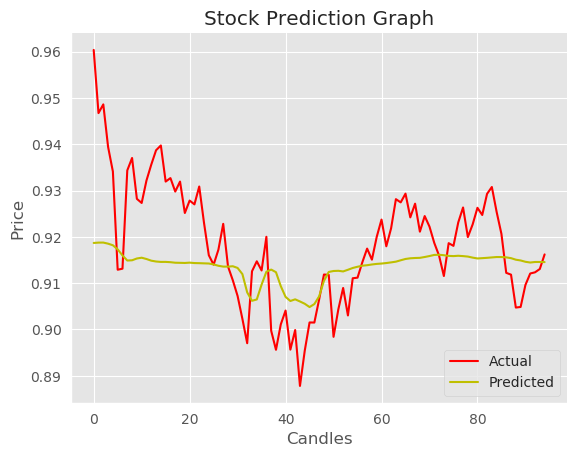

In [44]:
#gru model
calc(test_data, model2)

3/3 [==============================] - 0s 12ms/step


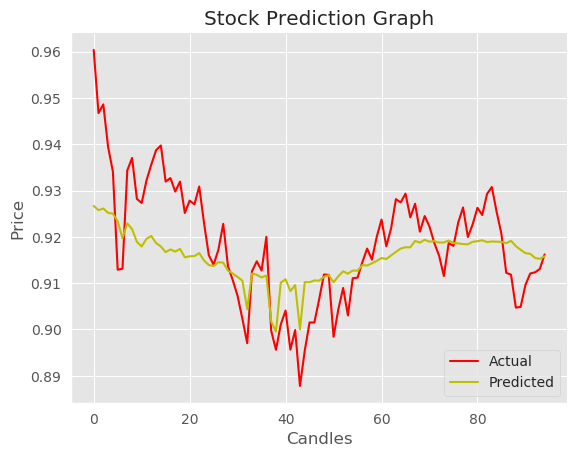

In [45]:
# sequential model
calc(test_data, model1)